# Correlation Analysis
---

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
## Load data
df_polls_2012 = pd.read_csv("Data\preprocessed\polls_2012.csv")
df_sentiment_obama_2012 = pd.read_csv("Data\preprocessed\sentiment_obama_2012.csv")
df_sentiment_romney_2012 = pd.read_csv("Data\preprocessed\sentiment_romney_2012.csv")

# Concat data
df_candidates_2012 = pd.concat(
    [df_sentiment_romney_2012, df_sentiment_obama_2012], ignore_index=True
)

# Cast to datetime type
df_polls_2012["Date_start"] = df_polls_2012["Date_start"].astype("datetime64[ns]")
df_polls_2012["Date_end"] = df_polls_2012["Date_end"].astype("datetime64[ns]")
df_sentiment_obama_2012["date"] = df_sentiment_obama_2012["date"].astype(
    "datetime64[ns]"
)
df_sentiment_romney_2012["date"] = df_sentiment_romney_2012["date"].astype(
    "datetime64[ns]"
)
df_candidates_2012["date"] = df_candidates_2012["date"].astype("datetime64[ns]")

<IPython.core.display.Javascript object>

## Data types and information
---

In [3]:
df_polls_2012.info()
print()
df_polls_2012.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Poll        328 non-null    object        
 1   Date        328 non-null    object        
 2   Sample      328 non-null    object        
 3   MoE         328 non-null    object        
 4   Obama (D)   328 non-null    float64       
 5   Romney (R)  328 non-null    float64       
 6   Spread      328 non-null    object        
 7   Date_start  328 non-null    datetime64[ns]
 8   Date_end    328 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 23.2+ KB



Poll           39
Date          287
Sample        175
MoE            29
Obama (D)      18
Romney (R)     18
Spread         23
Date_start    251
Date_end      237
dtype: int64

<IPython.core.display.Javascript object>

In [4]:
df_candidates_2012.info()
print()
df_candidates_2012.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29501 entries, 0 to 29500
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   quoteID                    29501 non-null  object        
 1   quotation                  29501 non-null  object        
 2   speaker                    29501 non-null  object        
 3   qids                       29501 non-null  object        
 4   date                       29501 non-null  datetime64[ns]
 5   numOccurrences             29501 non-null  int64         
 6   probas                     29501 non-null  object        
 7   urls                       29501 non-null  object        
 8   phase                      29501 non-null  object        
 9   month                      29501 non-null  object        
 10  type                       29501 non-null  object        
 11  candidate                  29501 non-null  object        
 12  quot

quoteID                      27416
quotation                    27416
speaker                       1611
qids                          1528
date                         13820
numOccurrences                 391
probas                       26428
urls                         19469
phase                            1
month                           11
type                             3
candidate                        2
quotation_tokenized          27403
quotation_stemmed            27085
quotation_lemmatized         27100
quotation_conc_lemmatized    27098
quotation_polarity            1634
quotation_subjectivity        1731
dtype: int64

<IPython.core.display.Javascript object>

## Preprocessing
***

### Aggregation

- #### By week

In [22]:
df_candidate = df_sentiment_romney_2012[["type", "date", "numOccurrences"]]

<IPython.core.display.Javascript object>

In [20]:
df_candidate.columns

Index(['date', 'numOccurrences', 'type'], dtype='object')

<IPython.core.display.Javascript object>

In [21]:
df_candidate.groupby(["type"]).head()

,date,numOccurrences,type
0,2012-01-22 16:16:00,3,NY Times
1,2012-04-21 03:06:13,15,NY Times
2,2012-06-23 04:29:31,1,NY Times
3,2012-01-01 01:26:46,29,NY Times
4,2012-04-04 01:38:50,40,NY Times
8933,2012-04-27 20:07:10,8,Fox News
8934,2012-10-09 12:46:57,1,Fox News
8935,2012-08-18 17:43:12,2,Fox News
8936,2012-04-13 21:06:52,1,Fox News
8937,2012-01-01 01:26:46,29,Fox News


<IPython.core.display.Javascript object>

- #### By survey period

In [5]:
candidate = "Romney (R)"
sentiment_dataset = df_sentiment_romney_2012
candidates_dataset = df_candidates_2012


def func_apply(x):
    """
    Take the mean of numOccurrences, quotation_polarity, quotation_subjectivity
    during a the period of time of the survey x. Also output the vote intention.
    """
    df_temp = sentiment_dataset.loc[
        (candidates_dataset.date >= x.Date_start)
        & (candidates_dataset.date < x.Date_end)
    ]

    return df_temp.describe().transpose()["mean"].append(pd.Series(x[candidate]))


df = df_polls_2012.apply(func_apply, axis=1)
df.dropna(inplace=True)
df.rename(columns={0: "intention"}, inplace=True)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numOccurrences,202.0,17.337344,8.305059,2.582418,13.054418,16.095203,20.170398,61.116279
quotation_polarity,202.0,0.068856,0.031203,-0.115152,0.052456,0.070351,0.087683,0.153393
quotation_subjectivity,202.0,0.308388,0.029839,0.228641,0.286538,0.307960,0.329108,0.427989
intention,202.0,44.995545,2.397766,38.000000,43.000000,45.000000,47.000000,50.000000


<IPython.core.display.Javascript object>

In [6]:
mmscaler = MinMaxScaler()
stdscaler = StandardScaler()
cols = df.columns

for col in cols:
    df[f"{col}_scaled"] = mmscaler.fit_transform(df[col].to_numpy().reshape(-1, 1))

for col in cols:
    df[f"{col}_standardized"] = stdscaler.fit_transform(
        df[col].to_numpy().reshape(-1, 1)
    )

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numOccurrences,202.0,1.733734e+01,8.305059,2.582418,13.054418,16.095203,20.170398,61.116279
quotation_polarity,202.0,6.885576e-02,0.031203,-0.115152,0.052456,0.070351,0.087683,0.153393
quotation_subjectivity,202.0,3.083882e-01,0.029839,0.228641,0.286538,0.307960,0.329108,0.427989
intention,202.0,4.499554e+01,2.397766,38.000000,43.000000,45.000000,47.000000,50.000000
numOccurrences_scaled,202.0,2.520751e-01,0.141885,0.000000,0.178905,0.230854,0.300475,1.000000
quotation_polarity_scaled,202.0,6.852025e-01,0.116193,0.000000,0.624133,0.690771,0.755310,1.000000
quotation_subjectivity_scaled,202.0,4.000400e-01,0.149685,0.000000,0.290431,0.397893,0.503977,1.000000
intention_scaled,202.0,5.829620e-01,0.199814,0.000000,0.416667,0.583333,0.750000,1.000000
numOccurrences_standardized,202.0,1.978615e-16,1.002484,-1.781033,-0.516982,-0.149936,0.341971,5.284454
quotation_polarity_standardized,202.0,-1.055261e-16,1.002484,-5.911766,-0.526890,0.048046,0.604870,2.715999


<IPython.core.display.Javascript object>

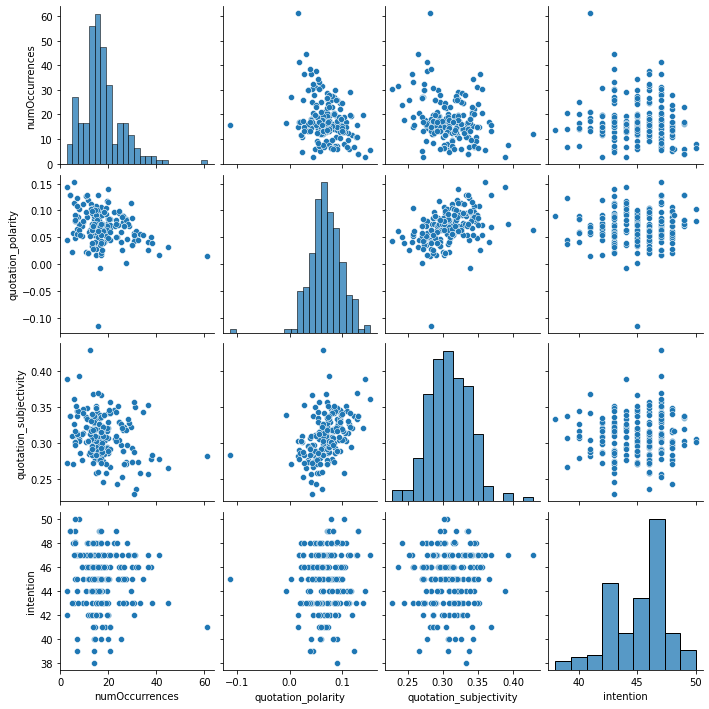

<IPython.core.display.Javascript object>

In [7]:
sns.pairplot(df.iloc[:, :4])

## Regression Analysis
---

In [8]:
mod = smf.ols(
    formula="intention ~ quotation_polarity + numOccurrences + quotation_subjectivity",
    data=df,
)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              intention   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8085
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.491
Time:                        16:12:59   Log-Likelihood:                -461.55
No. Observations:                 202   AIC:                             931.1
Df Residuals:                     198   BIC:                             944.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 44

<IPython.core.display.Javascript object>

In [9]:
mod = smf.ols(
    formula="intention_scaled ~ quotation_polarity_scaled + numOccurrences_scaled + quotation_subjectivity_scaled",
    data=df,
)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       intention_scaled   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8085
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.491
Time:                        16:12:59   Log-Likelihood:                 40.400
No. Observations:                 202   AIC:                            -72.80
Df Residuals:                     198   BIC:                            -59.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

<IPython.core.display.Javascript object>

Feature scaling does not seem to help.

In [10]:
mod = smf.ols(
    formula="intention_standardized ~ quotation_polarity_standardized + numOccurrences_standardized + quotation_subjectivity_standardized",
    data=df,
)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     intention_standardized   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                 -0.003
Method:                     Least Squares   F-statistic:                    0.8085
Date:                    Fri, 10 Dec 2021   Prob (F-statistic):              0.491
Time:                            16:12:59   Log-Likelihood:                -285.40
No. Observations:                     202   AIC:                             578.8
Df Residuals:                         198   BIC:                             592.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

<IPython.core.display.Javascript object>

In [11]:
corr, _ = pearsonr(df["intention"], df["numOccurrences"])
corr

-0.10509832347343104

<IPython.core.display.Javascript object>